# (3) Analysis of differentially expressed genes
---
Michaël Pierrelée, Aix Marseille Univ, CNRS, IBDM, UMR7288, FRANCE - michael.pierrelee@univ-amu.fr

*Apache License 2.0*

---

Results from the differential expression analysis are compared for the two workflows used. Moreover, sequences of transcripts related to the dysregulated genes are exported into a fasta file for downstream functional annotation.

Two workflows were applied in `2-differential_expression.r`: 1/ standard DESeq2 workflow with RLE (relative log expression) normalization ([Anders 2010](https://doi.org/10.1186/gb-2010-11-10-r106)), 2/ DESeq2 workflow with SVCD normalization ([Roca 2017](https://doi.org/10.1038/srep42460)).

Differentially expressed genes (DEG) were defined as genes with a FDR (adjusted p-value) lower than **0.01**, as the number of DEGs was already high for this threshold. However, for the Venn plot, a LFC cutoff of 1 in absolute value was also applied, although LFC cutoff can not be determined *a priori* and has no biological meaning *per se*.

At a given phase, the asymmetry between up- and down-regulated DEGs was calculated as the difference between the size of both classes divided by the size of the population (all DEGs). A value of + or - 100% means there is no down- or up-regulated genes, respectively, while a value of 0 happens when the sizes are even.

For the interaction terms with FDR lower than 0.01, the genes were categorized according to their "strength of variation". First, the log-fold changes in absolute value were normalized by min-max method. Second, they were split into 3 groups depending on the normalized LFCs: "low" was assigned to genes between $[0,0.33)$, "medium" between $[0.33,0.66)$ and "high" between $[0.66,1]$.

Finally, the DEGs with a FDR lower than 0.01 either at the E or S phases were kept for the downstream steps. The sequences of their transcripts, whose the name starts with the gene name, were retrieved from the list of Trinity-assembled transcripts and exported into a new fasta file, `degs_to_annotate.fasta`.

`M`, `F`, `E`, `S` denotes Marine and Fresh water; and Exponential and Stationary growth phases, respectively.

## Input

* `data/Trinity.fasta`: all transcripts assembled by Trinity.

Results from DESeq2 (within `data/dea_results`):
* `deseq-ME_vs_FE.csv` and `deseq-MS_vs_FS.csv`: samples from marine water M vs. fresh water F at exponential phase (E) and stationary phase (S) (resp.), using DESeq2 standard workflow.
* `svcd-ME_vs_FE.csv` and `svcd-MS_vs_FS.csv`: same, using SVCD replacing DESeq2 normalization step.
* `svcd-interaction_term.csv`: test if medium effect is different across phase, using SVCD workflow.
* `svcd-mean_norm_counts.csv`: normalized counts and their means in each condition, from SVCD workflow.

## Output
* `data/degs_to_annotate.fasta`: fasta sequences of all the DEGs in M vs. F that will be passed to BLAST.
* `data/dea_results/synthesis_deg_results.csv`: synthesis of DEA results with the mean of normalized counts, the LFCs and adjusted p-values of comparisons M vs. F at E and S and the interaction term values (LFC, padj and strength of variation in % and categorized into no significant, low, medium or strong variation).
* `data/dea_results/synthesis_dea_results.xslx`: same as above but for all DEA results.
* Figure `figures/venn-plot_degs.png`: Venn plot of genes with a low p-value and a high fold-change at the phases E and S and shared by both.
* Figure `figures/comparison_deseq_vs_svcd.png`: % of dysregulated genes and asymmetry in absolute value between up- and down-regulated genes from workflows with either RLE or SVCD as normalization methods.
* Figure `figures/asymmetry_up_down_degs.png`: asymmetry not in absolute value.
* Figure `figures/distri_lfcs_deseq_vs_svcd.png`: distribution of log-fold changes of dysregulated genes for both workflows.
* Figure `figures/padj_deseq_vs_svcd.png`: scatter plot of adjusted p-values converted by `-log10` for SVCD vs. RLE workflows.
* Figure `figures/lfc_deseq_vs_svcd.png`: scatter plot of log-fold changes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from Bio import SeqIO

In [2]:
import sys
from IPython.core.display import clear_output

def progress(cnt, k, N):
    """display a progress bar in the cell"""
    displayer = ['-', '\\', '|', '/']
    x = str( round(100*(k+1)/N, 1) ) + '%\t' + displayer[cnt]
    clear_output()
    sys.stdout.write(x)
    sys.stdout.flush()
    if cnt == 3: return 0
    else: return cnt + 1

In [3]:
sns.set(style='white')
# under this adjusted p-value threshold, a transcript is called DEG
padj_thresh = 0.01

## Data

In [4]:
# load results from the differential expression analysis
res = { 'deseq_E': pd.read_csv( '../data/dea_results/deseq2-ME_vs_FE.csv', index_col = 0 ),
        'deseq_S': pd.read_csv( '../data/dea_results/deseq2-MS_vs_FS.csv', index_col = 0 ), 
        'svcd_E': pd.read_csv( '../data/dea_results/svcd-ME_vs_FE.csv', index_col = 0 ), 
        'svcd_S': pd.read_csv( '../data/dea_results/svcd-MS_vs_FS.csv', index_col = 0 ),
        'iterm': pd.read_csv( '../data/dea_results/svcd-interaction_term.csv', index_col=0 )
      }

# mean of normalized counts
mean_counts = pd.read_csv( '../data/dea_results/svcd-mean_norm_counts.csv', index_col=0 )

# extract the DEGs
deg = { k: v[ v['padj'] <= padj_thresh
            ].rename( {'log2FoldChange': 'LFC'}, axis=1 ).loc[ :, ['LFC', 'padj'] ]
        for k, v in res.items() }

In [5]:
print( 'DEGs in M vs F at E :', len( set(deg['svcd_E'].index) ) )
print( 'DEGs in M vs F at S:', len( set(deg['svcd_S'].index) ) )
print( 'DEGs in M vs F at E or at S:', len( set(deg['svcd_E'].index) | set(deg['svcd_S'].index) ) )
print( 'DEGs in M vs F at E and at S:', len( set(deg['svcd_E'].index) & set(deg['svcd_S'].index) ) )

DEGs in M vs F at E : 5907
DEGs in M vs F at S: 6783
DEGs in M vs F at E or at S: 9117
DEGs in M vs F at E and at S: 3573


DEGs in M vs F at E or at S: 8214


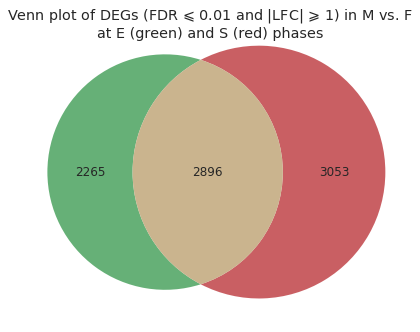

In [6]:
d2 = set( deg['svcd_E'][abs(deg['svcd_E']['LFC']) >= 1].index )
d4 = set( deg['svcd_S'][abs(deg['svcd_S']['LFC']) >= 1].index )
print( 'DEGs in M vs F at E or at S:', len( d2 | d4 ) )

fig, axes = plt.subplots(figsize=(7,7))

colors = sns.hls_palette(11, h=.6, l=.55, s=.5)
colors = sns.color_palette()
vn = venn2( (len( d2 - d4 ), len( d4 - d2 ), len( d2 & d4 )),
            set_labels=None, ax=axes,
            set_colors=(colors[2], colors[3]), alpha=0.9 )

plt.suptitle('Venn plot of DEGs (FDR $\leqslant$ 0.01 and |LFC| $\geqslant$ 1) in M vs. F\nat E (green) and S (red) phases', y=0.83)
plt.savefig('../figures/venn-plot_degs.png', format='png', bbox_inches='tight')
plt.show()

## Compare DESeq2 and SVCD normalization methods

### *Number of DEGs and asymmetry between up- and down-regulated genes*
% of DEGs for 10,000 genes in the genome

In [7]:
# comparisons between both methods
nb_genes = len(res['deseq_E'])
compar = { 'Number of DEGs in the transcriptome': {}, 'Asymmetry between up- and down-regulated DEGs': {} }
for d in deg:
    pos = len( deg[d][ deg[d]['LFC'] > 0 ] )
    neg = len( deg[d][ deg[d]['LFC'] < 0 ] )
    # number of differentially expressed genes in %
    compar['Number of DEGs in the transcriptome'][d] = 100 * len(deg[d]) / 10000
     # asymmetry between positive and negative DEGs in %
    compar['Asymmetry between up- and down-regulated DEGs'][d] = 100*(pos-neg) / (pos+neg)

# prepare for plotting
compar = pd.DataFrame(compar).rename({ 'deseq_E': 'DESeq2_E',
                                       'deseq_S': 'DESeq2_S',
                                       'svcd_E': 'SVCD_E',
                                       'svcd_S': 'SVCD_S' }
                            ).drop('iterm')
compar = compar.unstack().reset_index()
compar['method'], compar['day'] = compar['level_1'].str.split('_').str
compar = compar.drop('level_1', axis=1).rename({ 'level_0': '%', 0: 'value' }, axis=1)

compar

,%,value,method,day
0,Number of DEGs in the transcriptome,58.620000,DESeq2,E
1,Number of DEGs in the transcriptome,61.250000,DESeq2,S
2,Number of DEGs in the transcriptome,59.070000,SVCD,E
3,Number of DEGs in the transcriptome,67.830000,SVCD,S
4,Asymmetry between up- and down-regulated DEGs,-10.269533,DESeq2,E
5,Asymmetry between up- and down-regulated DEGs,-21.142857,DESeq2,S
6,Asymmetry between up- and down-regulated DEGs,-12.070425,SVCD,E
7,Asymmetry between up- and down-regulated DEGs,-54.975674,SVCD,S


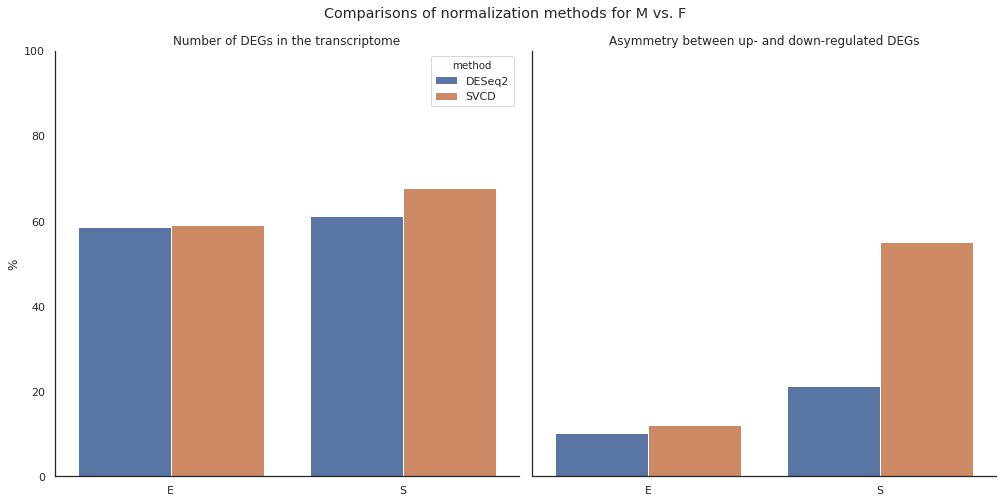

In [8]:
compar_abs = compar.copy()
compar_abs['value'] = abs(compar_abs['value'])

# plot
g = sns.catplot( x='day', y='value', hue='method', col='%', data=compar_abs, kind='bar', legend_out=False, height=7 )
g.set_axis_labels( '', '%'
                 ).set_titles( "{col_name}"
                 ).set( ylim=(0, 100) )
plt.suptitle('Comparisons of normalization methods for M vs. F', y=1.03)
plt.savefig('../figures/comparison_deseq_vs_svcd.png', format='png', bbox_inches='tight')
plt.show()

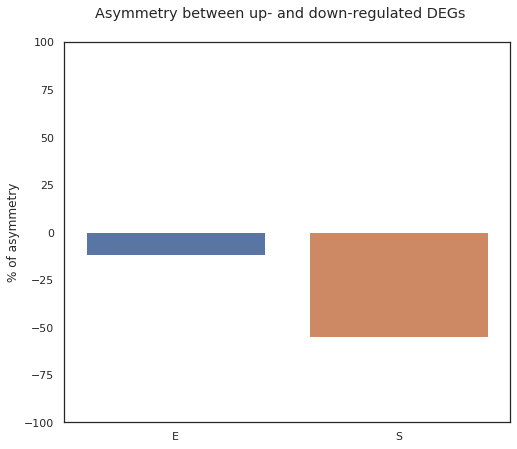

In [9]:
fig, ax = plt.subplots(figsize=(8,7))

g = sns.barplot(
    x = 'day', y = 'value',
    data = compar[ (compar['%'] == 'Asymmetry between up- and down-regulated DEGs') & (compar['method'] == 'SVCD') ]
)

g.set_ylabel('% of asymmetry')
g.set_xlabel('')
g.set_ylim(-100,100)
plt.suptitle('Asymmetry between up- and down-regulated DEGs', y=.95)
plt.savefig('../figures/asymmetry_up_down_degs.png', format='png', bbox_inches='tight')
plt.show()

### *Distribution of log fold changes*

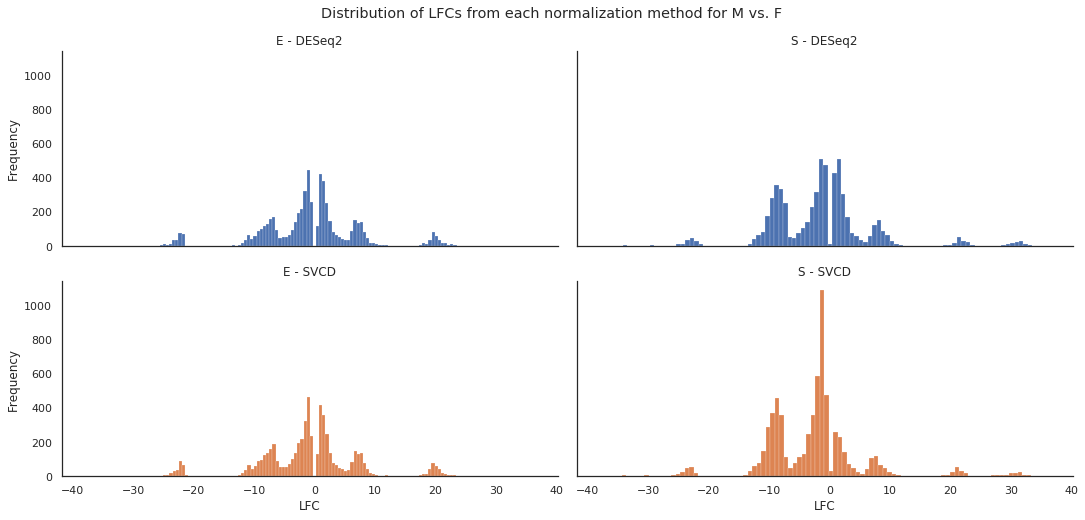

In [10]:
# prepare for plotting
hist_lfcs = pd.concat([deg['deseq_E']['LFC'].rename('DESeq2_E'),
                       deg['deseq_S']['LFC'].rename('DESeq2_S'),
                       deg['svcd_E']['LFC'].rename('SVCD_E'),
                       deg['svcd_S']['LFC'].rename('SVCD_S')],
                      axis=1, sort=True)
hist_lfcs = hist_lfcs.unstack().reset_index(
                              ).drop( 'level_1', axis=1
                              ).rename( {0: 'LFC'}, axis=1 )
hist_lfcs['method'], hist_lfcs['day'] = hist_lfcs['level_0'].str.split('_').str

# plot
g = sns.FacetGrid(hist_lfcs, col='day', hue='method', row='method', height=7/2, aspect=15/7)
g.map( plt.hist, 'LFC', bins=100, linewidth=0.2
     ).set_titles( '{col_name} - {row_name}'
     ).set_ylabels( 'Frequency')
plt.suptitle('Distribution of LFCs from each normalization method for M vs. F', y=1.03)
plt.savefig('../figures/distri_lfcs_deseq_vs_svcd.png', format='png', bbox_inches='tight')
plt.show()

In [11]:
print( 'number of positive DEGs at E:', len(deg['svcd_E'][deg['svcd_E']['LFC'] > 0]) )
print( 'number of negative DEGs at E:', len(deg['svcd_E'][deg['svcd_E']['LFC'] < 0]) )
print( 'number of positive DEGs at S:', len(deg['svcd_S'][deg['svcd_S']['LFC'] > 0]) )
print( 'number of negative DEGs at S:', len(deg['svcd_S'][deg['svcd_S']['LFC'] < 0]) )

number of positive DEGs at E: 2597
number of negative DEGs at E: 3310
number of positive DEGs at S: 1527
number of negative DEGs at S: 5256


### *Scatter plots between workflows*

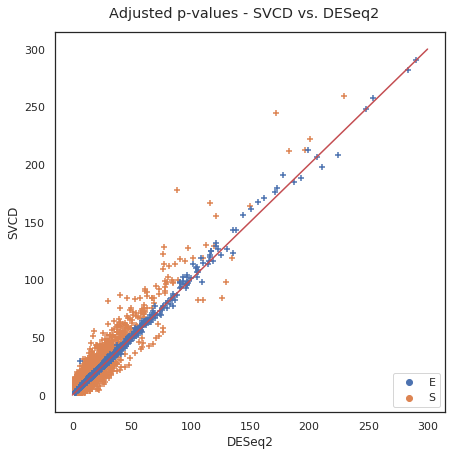

In [12]:
# prepare for plotting
df1 = pd.concat([ deg['deseq_E']['padj'].apply(lambda x: -np.log10(x)),
                  deg['svcd_E']['padj'].apply(lambda x: -np.log10(x)) ],
                axis=1, sort=True)
df2 = pd.concat([ deg['deseq_S']['padj'].apply(lambda x: -np.log10(x)),
                  deg['svcd_S']['padj'].apply(lambda x: -np.log10(x)) ],
                axis=1, sort=True)
df1.columns, df2.columns = [['DESeq2', 'SVCD']]*2
df1[''], df2[''] = 'E', 'S'
df = pd.concat([df2, df1])

# plot
ax, fig = plt.subplots(figsize=(7,7))
plt.suptitle('Adjusted p-values - SVCD vs. DESeq2', y=0.93)
g = sns.scatterplot(x='DESeq2', y='SVCD', hue='', hue_order=['E', 'S'], data=df, marker='+', linewidth=1.5)
g.legend(loc='lower right')
plt.plot((0,300), (0,300), 'r')
plt.savefig('../figures/padj_deseq_vs_svcd.png', format='png', bbox_inches='tight')
plt.show()

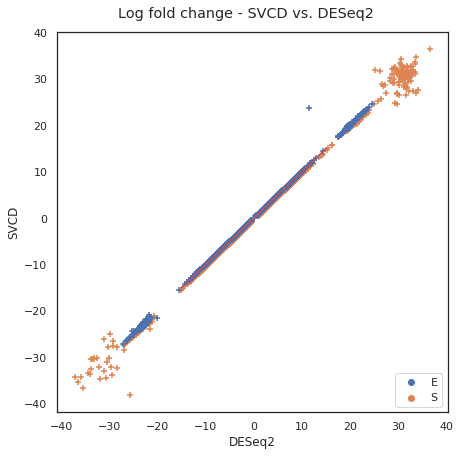

In [13]:
# prepare for plotting
df1 = pd.concat([ deg['deseq_E']['LFC'], deg['svcd_E']['LFC'] ], axis=1, sort=True)
df2 = pd.concat([ deg['deseq_S']['LFC'], deg['svcd_S']['LFC'] ], axis=1, sort=True)
df1.columns, df2.columns = [['DESeq2', 'SVCD']]*2
df1[''], df2[''] = 'E', 'S'
df = pd.concat([df2, df1])

# plot
ax, fig = plt.subplots(figsize=(7,7))
plt.suptitle('Log fold change - SVCD vs. DESeq2', y=0.93)
g = sns.scatterplot(x='DESeq2', y='SVCD', hue='', hue_order=['E', 'S'], data=df, marker='+', linewidth=1.5)
g.legend(loc='lower right')
plt.plot((-15,15), (-15,15), 'r')
plt.savefig('../figures/lfc_deseq_vs_svcd.png', format='png', bbox_inches='tight')
plt.show()

## Synthesis table and strength of variation between E and S
### *Categorize variations into 4 categories*

In [14]:
# normalization of variation
hist_var = abs( deg['iterm']['LFC'] )
hist_var = ( hist_var - hist_var.min() ) / ( hist_var.max() - hist_var.min() )

# categorization (values between 0.99 and 1 are called 'high2' and put in 'high category')
hist_var = pd.cut( hist_var, np.arange(0, 1.33, 0.33),
                   labels = [ 'low', 'medium', 'high', 'high2']
                 ).replace('high2', 'high' # high2=high for (0.99,1]
                 ).fillna('low') # for the value 0
hist_var.name = 'Strength of variation'

bins = hist_var.value_counts().sort_index()
print('number of transcripts in the category:')
print("- low [0.0, 0.33):", bins[bins.index[0]])
print("- medium [0.33, 0.66):", bins[bins.index[1]])
print("- high [0.66, 1]:", sum(bins[bins.index[2:]]))

number of transcripts in the category:
- low [0.0, 0.33): 2571
- medium [0.33, 0.66): 226
- high [0.66, 1]: 375


### *Synthesis*

In [15]:
#synthesis table
dea_results = mean_counts.copy()

dea_results = pd.concat([ dea_results,
                          res['svcd_E'].loc[ :, ['log2FoldChange', 'padj'] ].rename({ 'log2FoldChange': 'LFC E', 'padj': 'padj E' }, axis=1),
                          res['svcd_S'].loc[ :, ['log2FoldChange', 'padj'] ].rename({ 'log2FoldChange': 'LFC S', 'padj': 'padj S' }, axis=1)
                        ], axis=1, sort=True)

# variations of LFC
variations = 100*(dea_results['LFC S'] - dea_results['LFC E']) / dea_results['LFC E']
dea_results['Variation of LFC'] = variations
dea_results = dea_results.replace( [np.inf, -np.inf], np.nan )

# interaction term
iterm = res['iterm'].rename( { 'log2FoldChange': 'Interaction term LFC', 'padj': 'Interaction term padj' }, axis=1
                           ).loc[ :, ['Interaction term LFC', 'Interaction term padj'] ]
dea_results = pd.concat( [ dea_results, iterm,
                           hist_var[ set(dea_results.index) & set(hist_var.index) ] ], axis=1, sort=True )

# get subset for DEGs
all_degs = set(deg['svcd_E'].index) | set(deg['svcd_S'].index)
subset_results = dea_results.loc[ all_degs ]

In [16]:
dea_results.to_excel( '../data/dea_results/synthesis_dea_results.xlsx' )
subset_results.to_csv( '../data/dea_results/synthesis_deg_results.csv' )

## Prepare list of sequences for functional annotation

In [17]:
N = 0
with open( '../data/Trinity.fasta', 'r' ) as f:
    for line in f.readlines():
        if line.startswith('>'): N += 1

```python
fasta_degs = ''

# get transcripts of DEGs
cnt, index = 0, dea_results.index
with open( '../data/Trinity.fasta', 'r' ) as f:
    seq = False
    for k, line in enumerate( f.readlines() ):
        # get transcript header
        if line.startswith('>'):
            # get name of the gene
            seq_name = '_'.join( line[1:].split(' ')[0].split('_')[:4] )
            # if the sequence is an isoform of a DEG, save it
            if seq_name in index:
                fasta_degs += line
                seq = True
        # get transcript sequence
        elif seq:
            fasta_degs += line
            seq = False
        # progress bar
        cnt = progress(cnt, k/2, N)
        
# save the subset
with open('../data/degs_to_annotate.fasta', 'w') as f: f.write( fasta_degs )
```

In [18]:
x = 0
with open( '../data/degs_to_annotate.fasta', 'r' ) as f:
    for line in f.readlines():
        if line.startswith('>'): x += 1

print('initial number of transcripts:', N)
print('number of DEGs:', len(subset_results))
print('number of transcripts in the subset:', x)

initial number of transcripts: 103539
number of DEGs: 9117
number of transcripts in the subset: 39469
